# Used Car Database

### Context:

* This is basically a website which holds the database of all the cars registered for selling.
* Over 370000 used cars scraped with Scrapy from Ebay-Kleinanzeigen.
* The content of the data is in german, so one has to translate it first if one can not speak german.

### Problem Statement:

* This is a regression problem.
* To build a pricing model based on the given dataset.
* Data is collected till the year 2018.

### Overview:

* This dataset has 370000 registries of used cars.
* Each registry consists of information about a single car.

#### Target Variable:

* price: the price on the ad to sell the car

#### Features of data:

* dateCrawled : when this ad was first crawled, all field-values are taken from this date
* name : "name" of the car
* seller : private or dealer
* offerType
* abtest
* vehicleType: Type of the vehicle registered
* yearOfRegistration : at which year the car was first registered
* gearbox: automatic or manual
* powerPS : power of the car in PS
* model: model of the car registered
* kilometer : how many kilometers the car has driven
* monthOfRegistration : at which month the car was first registered
* fuelType: diesel, petrol, etc
* brand: brand of the car registered
* notRepairedDamage : if the car has a damage which is not repaired yet
* dateCreated : the date for which the ad at ebay was created
* nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless
* postalCode
* lastSeenOnline : when the crawler saw this ad last online

# Exploratory Data Analysis

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading the data

In [3]:
df=pd.read_csv("autos.csv", sep=',', header=0, encoding='cp1252')

In [4]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.shape

(371528, 20)

#### some features are numerical and some are categorical

In [6]:
df.dtypes[df.dtypes=="object"]

dateCrawled          object
name                 object
seller               object
offerType            object
abtest               object
vehicleType          object
gearbox              object
model                object
fuelType             object
brand                object
notRepairedDamage    object
dateCreated          object
lastSeen             object
dtype: object

### Distribution of numerical features.

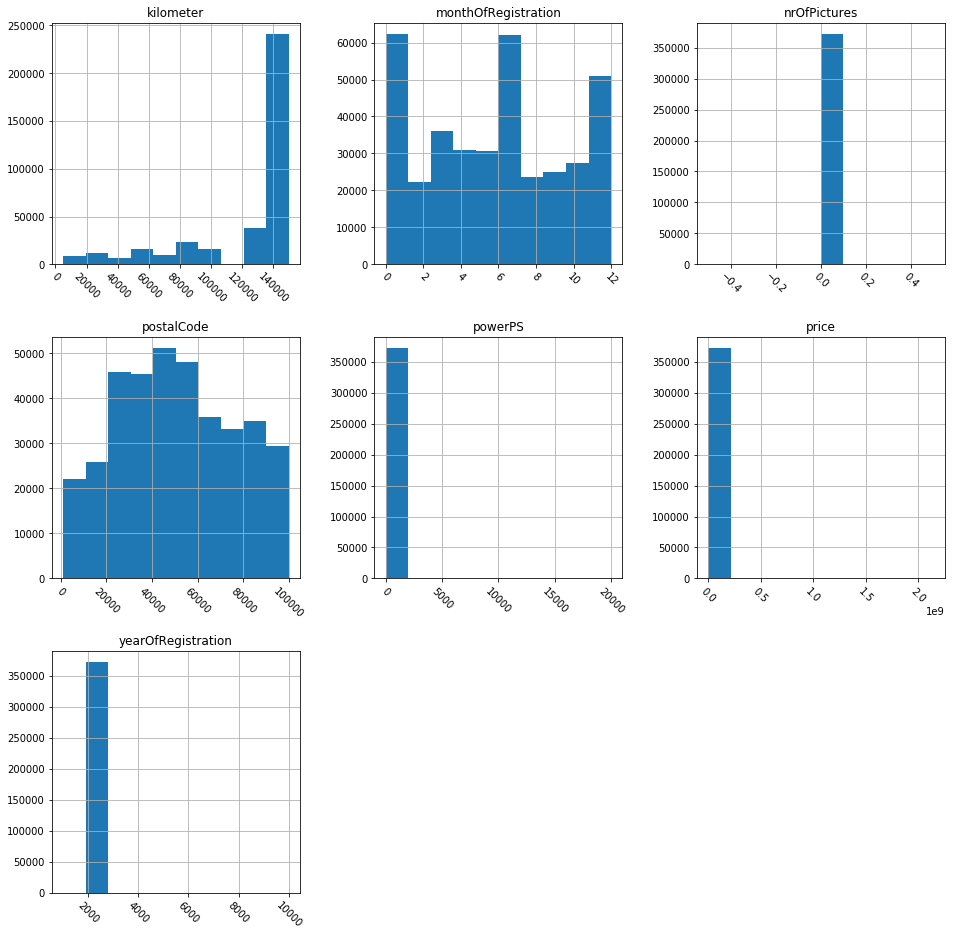

In [7]:
# Plot histogram grid
df.hist(figsize=(16,16), xrot=-45) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()

#### Observations:

* More than 200000 cars have kilometers > 140000. i.e our data has more cars that are old.
* we have less than 50000 cars which have kilometer value less than 140000 which is very scarce.

Take a look at the histagram for month of registration.
* most cars were registered in the month of january, june and december

In [8]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


#### Observations:

* The column yearOfRegistration has values greater than 2018 and minimum value as 1000, which is absurd.
* nrOfPictures has all values as '0'.Hence, this column can be dropped.
* The powerPS column has minimum value '0' and maximum value '20000' which is impossible. 

### Distribution of Categorical features.

In [25]:
df.describe(include=['object'])

,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage,dateCreated,lastSeen
count,371528,371528,371528,371528,371528,333659,351319,351044,338142,371528,299468,371528,371528
unique,280500,233531,2,2,2,8,2,251,7,40,2,114,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,test,limousine,manuell,golf,benzin,volkswagen,nein,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,657,371525,371516,192585,95894,274214,30070,223857,79640,263182,14450,17


#### Observations:

* Columns vehicleType, gearbox, model, fuelType, notRepaired have NaN values.

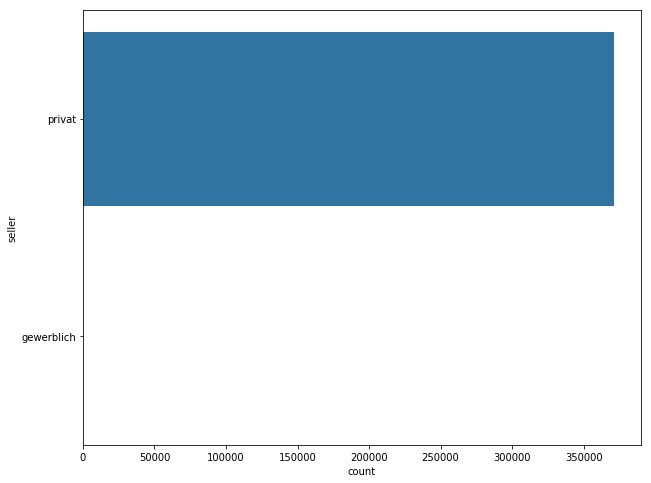

In [27]:
plt.figure(figsize=(10,8))
sns.countplot(y='seller', data=df)

In [28]:
df['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

#### Observations:
* class gewerblich has only 3 occurences.Therefore, it is a sparse class. 

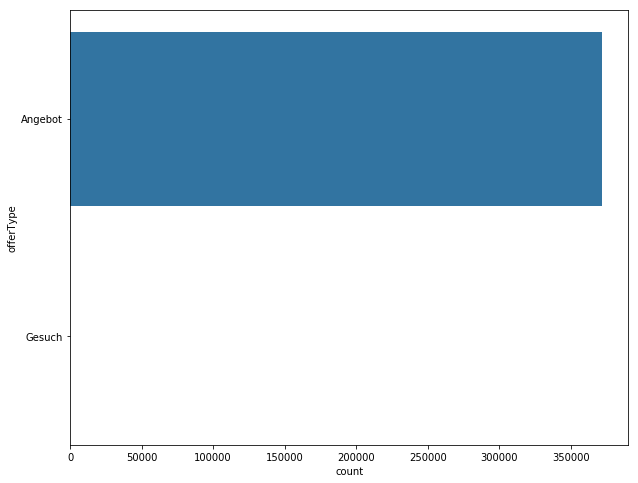

In [29]:
plt.figure(figsize=(10,8))
sns.countplot(y='offerType', data=df)

#### Observations:
* Again the class 'Gesuch' is a sparse class.

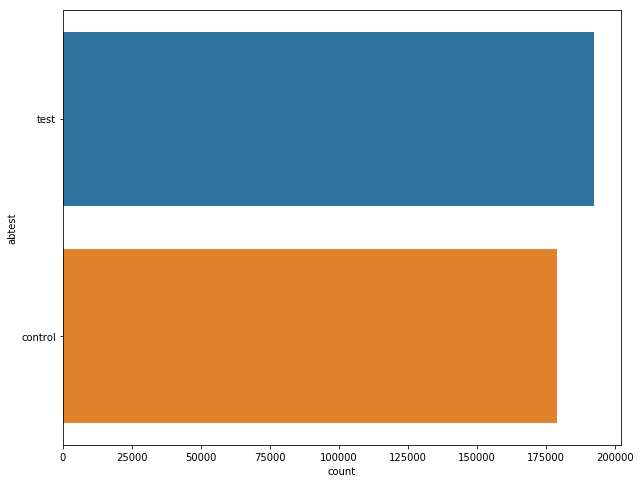

In [30]:
plt.figure(figsize=(10,8))
sns.countplot(y='abtest', data=df)

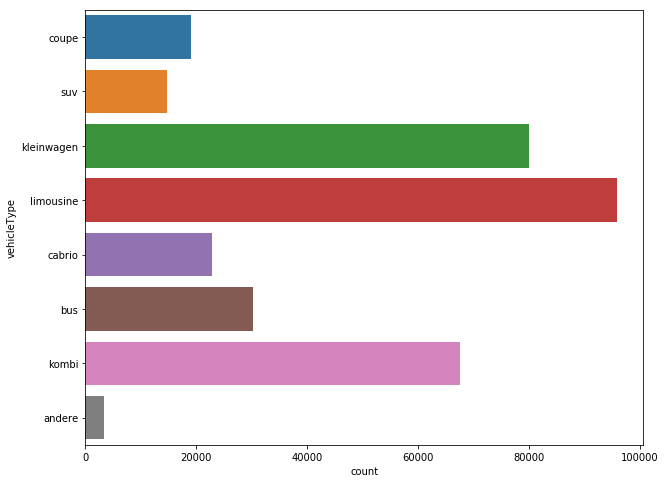

In [31]:
plt.figure(figsize=(10,8))
sns.countplot(y='vehicleType', data=df)

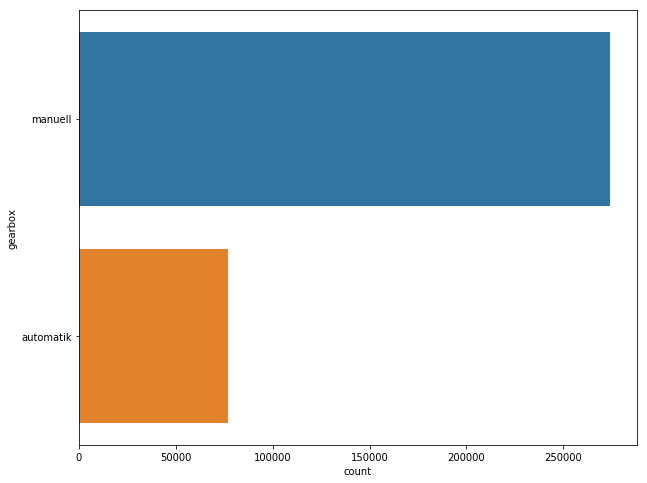

In [32]:
plt.figure(figsize=(10,8))
sns.countplot(y='gearbox', data=df)

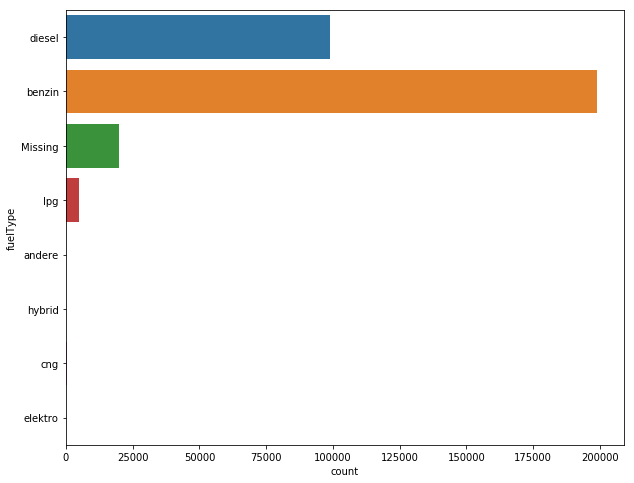

In [34]:
plt.figure(figsize=(10,8))
sns.countplot(y='fuelType', data=df)

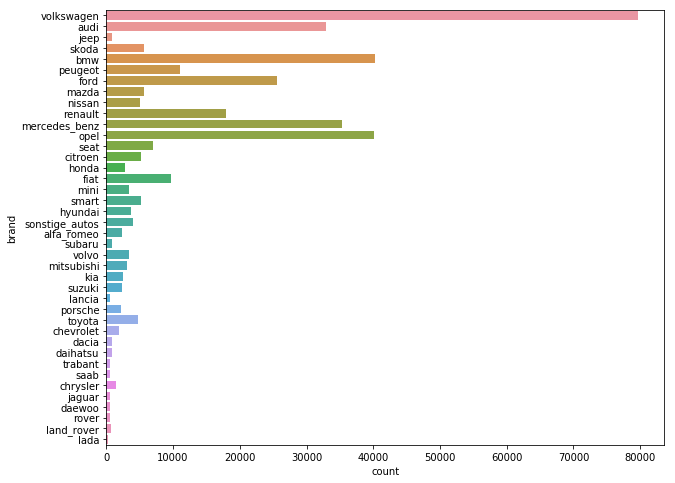

In [36]:
plt.figure(figsize=(10,8))
sns.countplot(y='brand', data=df)

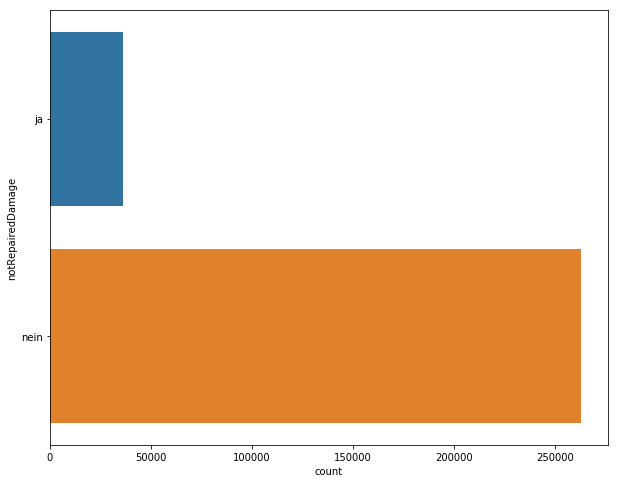

In [37]:
plt.figure(figsize=(10,8))
sns.countplot(y='notRepairedDamage', data=df)

#### Sparse classes need to be dealt with because they can cause the model to overfit.

### Segmentations

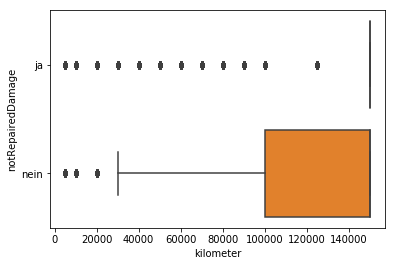

In [5]:
sns.boxplot(y='notRepairedDamage', x='kilometer', data=df)

#### Observations:

* Most old cars are damaged and repaired.
* few newly registered cars are not repaired.

In [9]:
df.corr()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,-0.000182,0.006850,-0.000635,-0.002826,NaN,-0.003164
yearOfRegistration,-0.000182,1.000000,0.000351,-0.055319,-0.011607,NaN,-0.001652
powerPS,0.006850,0.000351,1.000000,-0.010738,0.044358,NaN,0.027113
kilometer,-0.000635,-0.055319,-0.010738,1.000000,0.001838,NaN,-0.026694
monthOfRegistration,-0.002826,-0.011607,0.044358,0.001838,1.000000,NaN,0.014963
nrOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalCode,-0.003164,-0.001652,0.027113,-0.026694,0.014963,NaN,1.000000


#### Observations:

* nrOfPictures has all values NaN as it has standard deviation 0.

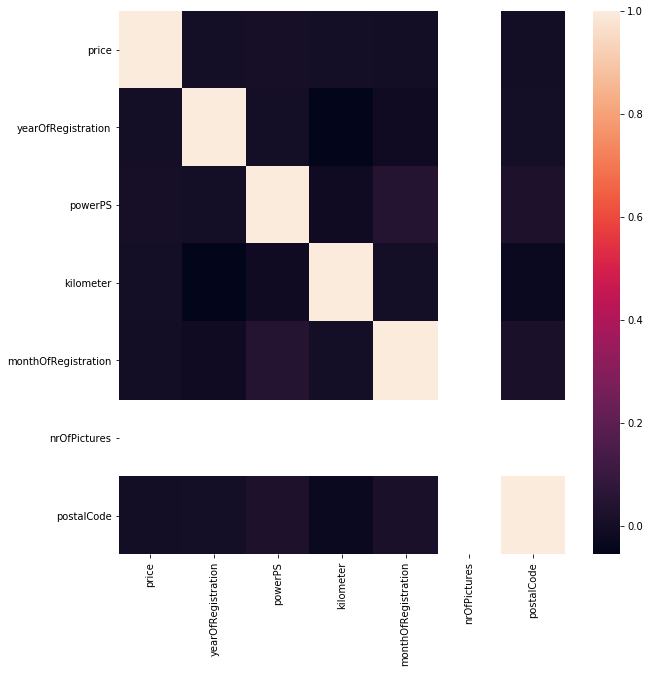

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

In [43]:
df.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.012869
kilometer              0.006082
yearOfRegistration     0.003519
monthOfRegistration    0.001511
Name: price, dtype: float64

* power is the most influencing feature for predicting price.

### Data Cleaning

#### Dropping duplicates

In [11]:
df=df.drop_duplicates()

In [13]:
df.shape

(371524, 20)

there were 4 duplicates in our data.

#### Removing outliers 

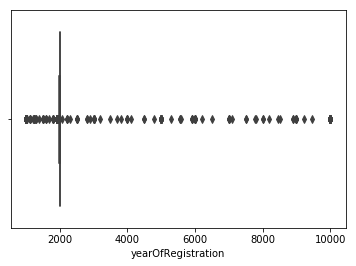

In [14]:
sns.boxplot(df.yearOfRegistration)

this column has values less than 1980 and 2018 which can be considered as outliers.

In [16]:
df=df[df.yearOfRegistration<2018]

In [17]:
df=df[df.yearOfRegistration>1980]

In [18]:
df.shape

(362642, 20)

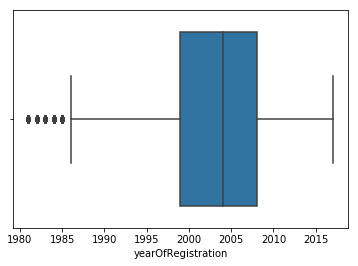

In [29]:
sns.boxplot(df.yearOfRegistration)

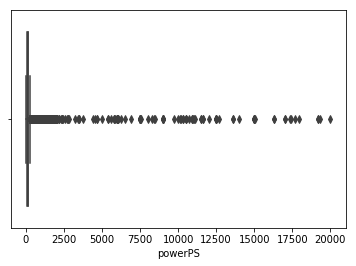

In [21]:
sns.boxplot(df.powerPS)

In [22]:
df=df[df.powerPS<500]

In [23]:
df=df[df.powerPS>0]

In [24]:
df.shape

(323559, 20)

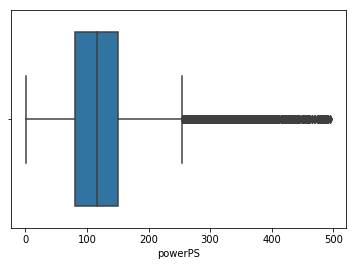

In [28]:
sns.boxplot(df.powerPS)

In [38]:
df=df[df.price>100]

In [39]:
df.shape

(315087, 20)

#### Checking null values in Categorical Data

In [30]:
df.select_dtypes(include=['object']).isnull().sum()

dateCrawled              0
name                     0
seller                   0
offerType                0
abtest                   0
vehicleType          19806
gearbox               6233
model                12879
fuelType             19863
brand                    0
notRepairedDamage    48538
dateCreated              0
lastSeen                 0
dtype: int64

In [31]:
df['vehicleType'] = df['vehicleType'].fillna('Missing')
df['gearbox'] = df['gearbox'].fillna('Missing')
df['model'] = df['model'].fillna('Missing')
df['fuelType'] = df['fuelType'].fillna('Missing')
df['notRepairedDamage'] = df['notRepairedDamage'].fillna('Missing')

In [32]:
df.select_dtypes(include=['object']).isnull().sum()

dateCrawled          0
name                 0
seller               0
offerType            0
abtest               0
vehicleType          0
gearbox              0
model                0
fuelType             0
brand                0
notRepairedDamage    0
dateCreated          0
lastSeen             0
dtype: int64

#### Checking null values in Numerical Data.

In [35]:
df.select_dtypes(exclude=['object']).isnull().sum()

price                  0
yearOfRegistration     0
powerPS                0
kilometer              0
monthOfRegistration    0
nrOfPictures           0
postalCode             0
dtype: int64

### Feature Engineering

#### Dropping useless features.

* The following features have no relevance for the given problem.Hence, dropping these features.

In [40]:
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis=1, inplace=True)

In [41]:
df.shape

(315087, 12)

#### Handling sparse classes.

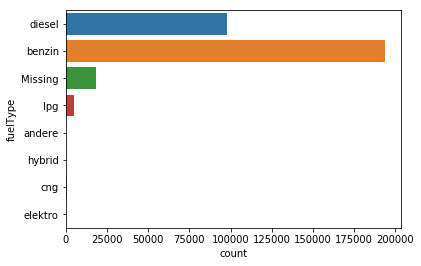

In [44]:
sns.countplot(y='fuelType', data=df)

In [45]:
df.fuelType.replace(['andere', 'hybrid', 'cng', 'elektro', 'lpg'], 'andere', inplace=True)

* "andere" is a German word which means "others" in English

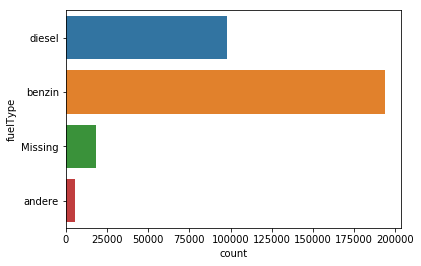

In [48]:
sns.countplot(y='fuelType', data=df)

#### Indicator Varibles.

In [51]:
df.kilometer.value_counts()

150000    202118
125000     33667
100000     13598
90000      11182
80000       9943
70000       8839
60000       7944
50000       6921
40000       5863
30000       5405
20000       4855
5000        3206
10000       1546
Name: kilometer, dtype: int64

In [63]:
df['Too_new_cars'] = (df.kilometer <= 5000).astype(int)

In [64]:
df[df['Too_new_cars']==1].shape[0]/df.shape[0]

0.010174967548645294

1% of the data has all new cars.

In [65]:
df.powerPS.value_counts()

75     22669
60     14951
150    14785
140    13280
101    12762
90     11951
116    11615
170    10641
105    10164
125     6729
136     6711
102     6306
163     6156
143     5457
54      5412
122     5217
131     5052
109     4708
110     4657
50      4180
80      3902
177     3823
120     3761
58      3713
69      3549
115     3025
95      2912
68      2736
184     2692
45      2677
       ...  
443        2
348        2
481        2
483        2
417        1
473        1
331        1
319        1
477        1
332        1
339        1
424        1
32         1
459        1
454        1
453        1
361        1
297        1
366        1
490        1
462        1
397        1
442        1
282        1
22         1
312        1
434        1
468        1
337        1
323        1
Name: powerPS, Length: 441, dtype: int64

In [70]:
df['cars_with_high_PS'] = (df.powerPS >= 300).astype(int)

In [71]:
df[df['cars_with_high_PS']==1].shape[0]/df.shape[0]

0.01965806269379568

0.19% of the data has cars with very high horsepower.

In [74]:
df.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.012869
Too_new_cars           0.007762
kilometer              0.006082
cars_with_high_PS      0.005446
yearOfRegistration     0.003519
monthOfRegistration    0.001511
Name: price, dtype: float64

* Our new features are influencing the price quite well. :D
* We also created column "cars_with_low_PS" but it was not helping much.Hence we dropped it.

In [9]:
df.to_csv('new_autos.csv', index=None)

In [3]:
df=pd.read_csv("new_autos.csv")

### One Hot Encoding.

In [10]:
df.describe(include='object')

,name,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
count,315087,315087,315087,315087,315087,315087,315087
unique,192666,9,3,250,4,40,3
top,BMW_318i,limousine,manuell,golf,benzin,volkswagen,nein
freq,620,86065,240206,26293,193607,67801,240750


In [11]:
df = pd.get_dummies(df, columns=['vehicleType', 'gearbox', 'fuelType','notRepairedDamage','brand','model'])

In [4]:
df.head()

,name,price,yearOfRegistration,powerPS,model,kilometer,monthOfRegistration,Too_new_cars,cars_with_high_PS,vehicleType_Missing,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,A5_Sportback_2.7_Tdi,18300,2011,190,Missing,125000,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Jeep_Grand_Cherokee_""Overland""",9800,2004,163,grand,125000,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GOLF_4_1_4__3TÜRER,1500,2001,75,golf,150000,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Skoda_Fabia_1.4_TDI_PD_Classic,3600,2008,69,fabia,90000,7,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,1995,102,3er,150000,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Machine Learning Models.

In [10]:
#Taking a sample of 100000 points.
df1=df.sample(n=100000,random_state=123)

In [11]:
df1.shape

(100000, 317)

In [59]:
y=df1.price
X=df1.drop(['name','price'], axis=1)

#### Test Train split

In [60]:
# preforming a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [61]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 315) (30000, 315) (70000,) (30000,)


## Ridge Regression

In [62]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Ridge(), tuned_params, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [63]:
model.best_estimator_

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [64]:
y_train_pred = model.predict(X_train)

In [65]:
y_pred = model.predict(X_test)

### Feature Importance

In [66]:
model = Ridge(alpha=100000)
model.fit(X_train, y_train)

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [69]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
fuelType_Missing
notRepairedDamage_Missing
monthOfRegistration
notRepairedDamage_nein
fuelType_benzin
model_mondeo
model_golf
brand_ford
yearOfRegistration
fuelType_diesel
brand_volkswagen
vehicleType_kombi
vehicleType_Missing
vehicleType_limousine
gearbox_manuell
brand_opel
notRepairedDamage_ja
brand_bmw
brand_audi
gearbox_automatik
model_3er
vehicleType_kleinwagen
vehicleType_bus
brand_renault
model_clk
cars_with_high_PS
vehicleType_coupe
model_punto
brand_peugeot
model_passat
gearbox_Missing
model_5er
model_andere
fuelType_andere
model_a4
powerPS
brand_porsche
model_astra
model_911
model_focus
model_c_klasse
brand_fiat
model_a6
model_Missing
model_e_klasse
brand_seat
brand_mercedes_benz
brand_citroen
brand_skoda
model_2_reihe
brand_mazda
model_corsa
model_vectra
model_transporter
brand_hyundai
model_fiesta
brand_alfa_romeo
model_a3
vehicleType_cabrio
model_touran
model_zafira
model_polo
brand

### Random Forest Regression. 

In [73]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
model.best_estimator_

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
y_pred = model.predict(X_test)

### Feature Importance

In [ ]:
model = RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=4)
model.fit(X_train, y_train)

In [ ]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)